In [105]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

font = cv2.FONT_HERSHEY_SIMPLEX
facedata = "classifier/haarcascade_frontalface_default.xml"
cascade = cv2.CascadeClassifier(facedata)

TRAIN_DIR = 'trainfaces'
TEST_DIR = 'testfaces'
IMG_SIZE = 50
LR = 1e-3
label_names = ['pranav_raut', 'tilak_rinait']

MODEL_NAME = 'reg_faces-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [106]:
def label_img(img):
    word_label = img.split('.')[0]
    arr = [0] * len(label_names); 
    arr[label_names.index(word_label)] = 1;
    return arr

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [110]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [111]:
train_data = create_train_data()
#train_data = np.load('train_data.npy')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 119  | total loss: 0.10669 | time: 3.133s
| Adam | epoch: 010 | loss: 0.10669 - acc: 0.9973 -- iter: 704/728
Training Step: 120  | total loss: 0.10436 | time: 4.442s
| Adam | epoch: 010 | loss: 0.10436 - acc: 0.9976 | val_loss: 0.08887 - val_acc: 0.9940 -- iter: 728/728
--
INFO:tensorflow:E:\Google Drive\College\College work\TEB647\ML\Automatic-Attendance-System-in-Python\reg_faces-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 516.72it/s]


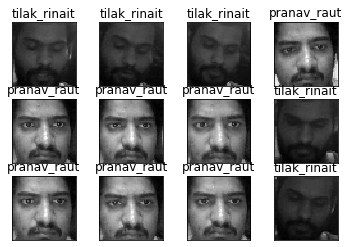

In [116]:
import matplotlib.pyplot as plt

test_data = process_test_data()

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    v = np.amax(model_out)
    name = label_names[np.where(model_out == v)[0][0]]
        
    y.imshow(orig, cmap='gray')
    plt.title(name)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [113]:
import cv2
import time
import sys

cam = cv2.VideoCapture(0)

cv2.namedWindow("recognize faces")

while True:
    ret, frame = cam.read()
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        print("\nEscape hit, closing...")
        break

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(gray_img)
    
    str_label, v = "", 0
    cv2.imshow("recognize faces", frame)

    for f in faces:
        x, y, w, h = [ v for v in f ]

        sub_face = gray_img[y:y+h, x:x+w]
        orig = cv2.resize(sub_face, (IMG_SIZE,IMG_SIZE))
        data = np.array(orig).reshape(IMG_SIZE, IMG_SIZE, 1)

        model_out = model.predict([data])[0]
        v = np.amax(model_out)
        name = label_names[np.where(model_out == v)[0][0]]
        str_label +=  "%s (%s), " % (name, v)
        sys.stdout.flush()
        
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 255), 4)
        cv2.putText(frame, name, (x - 20, y - 20), font, 1, (255, 255, 255), 2)
        cv2.imshow("recognize faces", frame)
        
    if str_label == "":
        str_label = "No Faces"
    else:
        str_label = str_label[:-2]
    print(('#' * 20) + " " + str_label + " " + ('#' * 20), end="\r")

cam.release()

cv2.destroyAllWindows()

#################### pranav_raut (0.9994018) #####################
Escape hit, closing...


### CREATE DATASET

In [90]:
import cv2
import time

cam = cv2.VideoCapture(0)

cv2.namedWindow("capture faces")

for i in range(1, 100):    
    ret, frame = cam.read()
    if not ret:
        break

    cv2.imshow("capture faces", frame)
    k = cv2.waitKey(1)

    if k%256 == 27:
        print("\nEscape hit, closing...")
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(frame)

    for f in faces:
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255,255,255))

        sub_face = frame[y:y+h, x:x+w]

#         img_name = "testfaces/pranav_raut.%s.jpg" % i
        img_name = "trainfaces/pranav_raut.%s.jpg" % i

        cv2.imwrite(img_name, sub_face)
    
cam.release()

cv2.destroyAllWindows()